# Diving photo tuning

I'm a scuba diver, and I like taking photos underwater. Some people recommend using a plastic magenta filter, but I don't think that's too smart, since any filter will diminish the amount of light that comes into the lens. If what we want with a filter is color correction, we can do that programmatically, and that's what I want to achieve with this notebook.

I've been manually editing my diving photos with a number of image editing softwares, but I want to create something to improve my photos automatically.

What I want to do, in a few words, is making red shades stronger, green ones weaker, and tuning contrast up a notch.

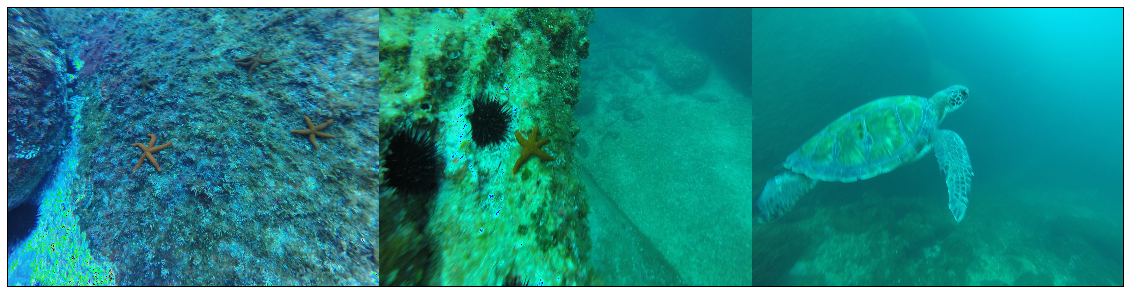

In [38]:
import scipy.ndimage as ndi
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

def plotImage(image):
    plt.figure(figsize=(20,10))
    imagePlotting = plt.imshow(image)
    imagePlotting.axes.get_xaxis().set_visible(False)
    imagePlotting.axes.get_yaxis().set_visible(False)
    plt.show()
    
def makeImageStripe(images):
    result = numpy.zeros([width*3, height,3]);

    def copyIntoArray(origin, target, fromX, toX):
        target[...,0][fromX:toX] = 255-origin.T[0,...]
        target[...,1][fromX:toX] = 255-origin.T[1,...]
        target[...,2][fromX:toX] = 255-origin.T[2,...]

    copyIntoArray(images[0], result, 0, width)
    copyIntoArray(images[1], result, width, width*2)
    copyIntoArray(images[2], result, width*2, width*3)

    result = result.transpose(1,0,2)
    
    return result


dive1 = ndi.imread("images/dive1.jpg")
dive2 = ndi.imread("images/dive2.jpg")
dive3 = ndi.imread("images/dive3.jpg")

width = len(dive1[0])
height = len(dive1)

stripe = makeImageStripe([dive1, dive2, dive3])

plotImage(stripe)

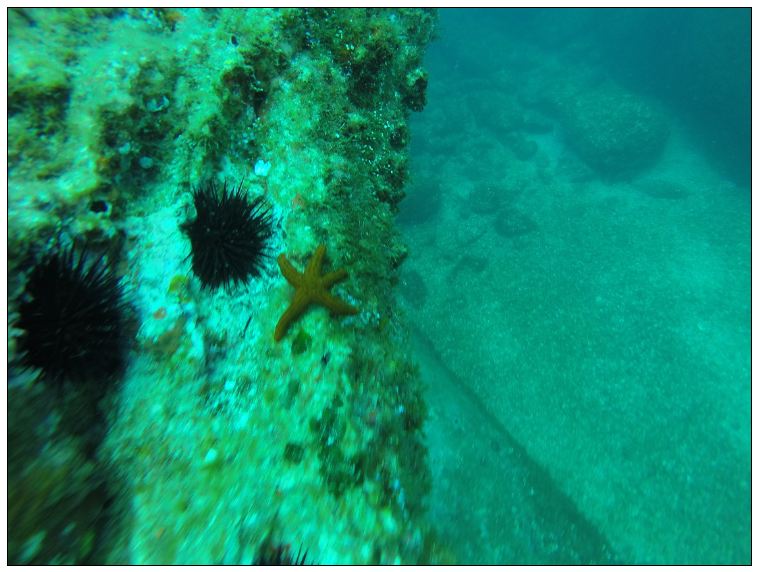

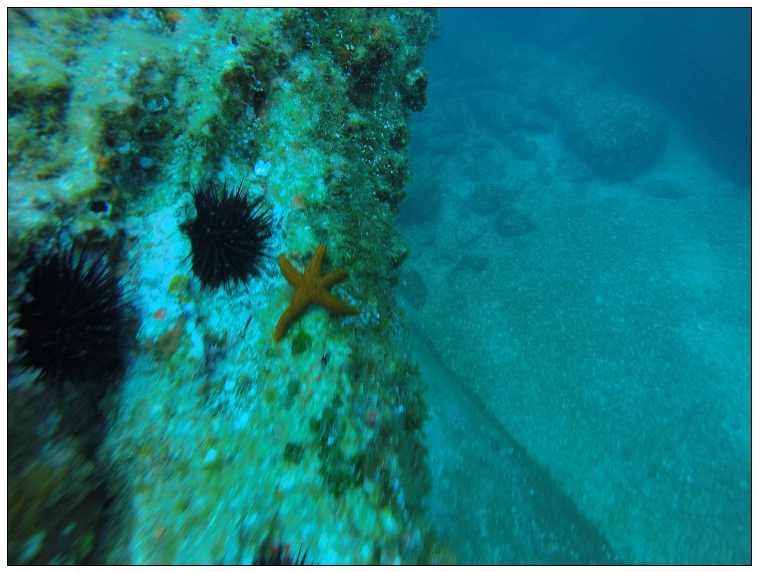

In [46]:
dive1leveled = dive2.copy()

for x in range(width):
    for y in range(height):
        dive1leveled[y][x][0] = min([dive2[y][x][0] * 1.3, 255])
        dive1leveled[y][x][1] = max([dive2[y][x][1] * 0.85, 0])
        dive1leveled[y][x][2] = min([dive2[y][x][2] * 1.1, 255])

stripe = makeImageStripe([dive1, dive1leveled, dive1leveled])
plotImage(dive2)
plotImage(dive1leveled)

In [63]:
from PIL import Image
from PIL import *
from numpy import *
from functools import *

def histeq(im,nbr_bins=256):
  #get image histogram
  imhist,bins = histogram(im.flatten(),nbr_bins,normed=True)
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = 255 * cdf / cdf[-1] # normalize

  # use linear interpolation of cdf to find new pixel values
  im2 = interp(im.flatten(),bins[:-1],cdf)

  return im2.reshape(im.shape)

import operator

def equalize(im):
    h = im.convert("L").histogram()
    lut = []
    for b in range(0, len(h), 256):
        # step size
        step = reduce(operator.add, h[b:b+256]) / 255
        # create equalization lookup table
        n = 0
        for i in range(256):
            lut.append(n / step)
            n = n + h[i+b]
    # map image through lookup table
    return im.point(lut*im.layers)

In [64]:
sharpened = equalize(Image.fromarray(dive1leveled))

plotImage(dive1leveled)
plotImage(sharpened)

AttributeError: layers